In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import pandas as pd
import numpy as np
import healpy as hp
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from astropy.io import fits
from tqdm import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import iminuit
from iminuit import Minuit, describe, Struct
import re

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

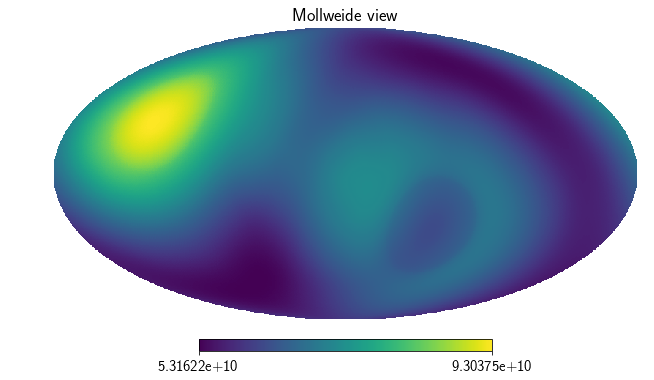

In [98]:
FermiData = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
hp.mollview(fermi_exposure)
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')
psc = np.load('fermi_data/template_psc.npy')
subhalos = np.load('MC/EinastoTemplate2.npy')
subhalos = subhalos

The number of parameters to be fit is 3
Template best-fit params are [13.9583217   1.06289421  0.90448092]


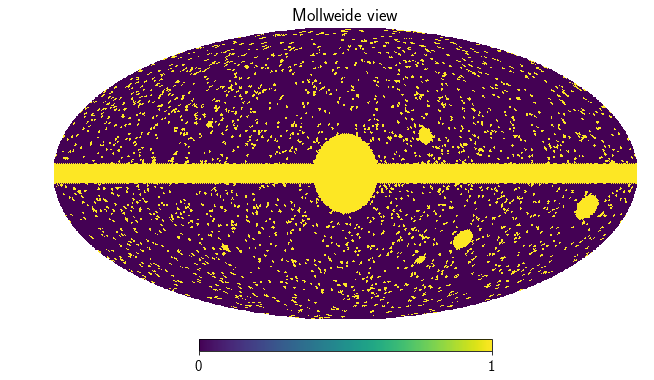

In [99]:
n = nptfit.NPTF(tag='norm')
n.load_data(FermiData, fermi_exposure)

pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
hp.mollview(mask)
n.load_mask(mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')

n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,10], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,10], False)

n.configure_for_scan()
scpy_min = minimize(lambda x: -n.ll(x), x0=[1.,1.,1], bounds=[[0.,30],[0.,30],[0.,30]], options={'disp':False,'ftol':1e-12}, method='SLSQP')
max_LL = -scpy_min['fun']
best_fit_params = scpy_min['x']
print("Template best-fit params are", best_fit_params)

In [36]:
fake_data_arr = [] 
xsec_inj = np.array([1e-22]) #(np.logspace(-30, -20, 10))[:-3]
trials = 1
for t in range(trials):
    fake_data_arr2 = []
    for fac in xsec_inj * 1e22:
        fake_data = 13.9583217*dif + 1.06289421*iso + 0.90448092*psc
        #fake_data = np.random.poisson(fake_data).astype(np.float64)
        #fake_data = np.load("/tigress/somalwar/Subhaloes/Subhalos/MC/subhalo_flux_map"+str(t)+"_10-15.npy")*fermi_exposure*fac 
        fake_data = np.load("MC/subhalo_flux_map0.npy")*fermi_exposure*fac
        fake_data = np.round(fake_data).astype(np.int32)
        fake_data_arr2.append(fake_data)
    fake_data_arr.append(fake_data_arr2)

In [38]:
LL_xsec_ary_arr = []
new_n_arr = []
d_arr_ary = []
for fi, fake_data_arr2 in enumerate(fake_data_arr):
    new_n_arr2 = []
    for fi, fake_data in enumerate(fake_data_arr2):
        n = nptfit.NPTF(tag='norm')
        n.load_data(fake_data, fermi_exposure)
        pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
        mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
        n.load_mask(mask)

        dif_copy = dif.copy()
        iso_copy = iso.copy()
        psc_copy = psc.copy()
        subhalos_copy = subhalos.copy()

        n.add_template(dif_copy, 'dif')
        n.add_template(iso_copy, 'iso')
        n.add_template(psc_copy, 'psc')

        n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
        n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
        n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,20], False)

        area_mask = len(mask[~mask])/len(mask) * 4*np.pi * (180/np.pi)**2
        xsec0 = 1e-22

        A0 = 10**(3.53399)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])
        n20 = 1.89914
        n10 = 10.0
        Fb0 = 10**(-7.71429)*np.average(fermi_exposure[~mask])    

#         A0 = 3.99418e-06 #1.39885e-06
#         n10 = 10.0
#         n20 = 1.33279863 #1.80089
#         Fb0 = 3640.23 #1264.28

        A0 = 10**(3.72097162)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])
        n20 = 1.79403567
        n10 = 10.0
        Fb0 = 10**(-7.71429)*np.average(fermi_exposure[~mask])    
        print(np.log10(A0), np.log10(Fb0))

        new_n = copy.copy(n)
        new_n.add_template(subhalos_copy, 'subhalos', units='PS')
        new_n.add_non_poiss_model('subhalos', 
                               ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$F_b$'],
                                  fixed_params=[ [1,n10], [2,n20] ],
                                  units='counts')
        new_n.configure_for_scan(nexp=20)
        new_n_arr2.append(new_n)
    new_n_arr.append(new_n_arr2)

-5.826500361485184 3.1018415719759265
The number of parameters to be fit is 5


In [ ]:
xsec_rec = []
xsec_test = np.logspace(-40, -20, 101)
best_fit_params_arr = []
ll_xsec = []
for t in range(trials):
    ll_xsec.append([])
    for ix in tqdm_notebook(range(len(xsec_inj))):
        ll_xsec[-1].append([])
        for xsec in xsec_test:
            #minuit_min = iminuit.Minuit(lambda d, i, p: -new_n_arr[t][ix].ll([d, i, p, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]), d=13.9583217, i=1.06289421, p=0.90448092, fix_d=True, fix_i=True, fix_p=True, limit_d=(0.,20.), limit_i=(0.,3.), limit_p=(0.,3.), error_d=1e-1, error_i=1e-1, error_p=1e-1, print_level=1);
            minuit_min = iminuit.Minuit(lambda d, i, p: -new_n_arr[t][ix].ll([d, i, p, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]), d=0., i=0., p=0., fix_d=True, fix_i=True, fix_p=True, limit_d=(0.,20.), limit_i=(0.,3.), limit_p=(0.,3.), error_d=1e-1, error_i=1e-1, error_p=1e-1, print_level=1);
            minuit_min.migrad();
            ll=minuit_min.fval
            ll_xsec[t][ix].append(ll)

In [ ]:
xsec_rec = []
xsec_max = []
for t in range(trials):
    xsec_rec2 = []
    xsec_max2 = []
    for ix in range(len(xsec_inj)):
        ll_xsec[t][ix] = np.array(ll_xsec[t][ix])
        TS = -2*(ll_xsec[t][ix] - ll_xsec[t][ix][0])
        TS_max = np.amax(TS)
        argmax = np.argmax(TS)
        plt.plot(xsec_test, TS-TS_max)
        for ix, xsec in enumerate(xsec_test[argmax:]):
            if TS_max - TS[argmax+ix] > 2.71:
                xsec_rec2.append(xsec)
                xsec_max2.append(xsec_test[argmax])
                break
    xsec_rec.append(xsec_rec2)
    xsec_max.append(xsec_max2)
plt.xscale("log")
plt.ylim(-12, 3)

In [ ]:
print(xsec_rec)

[[1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23], [1e-22, 1e-22, 1e-22, 1e-22, 1e-22]]


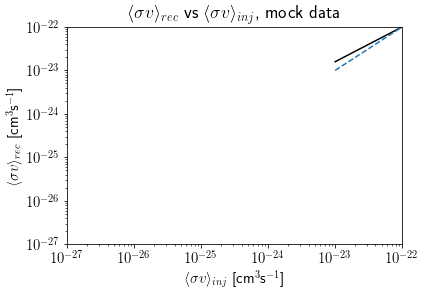

In [96]:
xsec_rec_arr = []
for ix in range(len(xsec_inj)):
    xsec_rec_arr2 = []
    for t in range(trials):
        xsec_rec_arr2.append(xsec_rec[t][ix])
    xsec_rec_arr.append(xsec_rec_arr2)
print(xsec_rec_arr)
plt.plot(xsec_inj, np.percentile(xsec_rec_arr, 50, axis=1), c="black")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 2.5, axis=1), np.percentile(xsec_rec_arr, 97.5, axis=1), facecolor="yellow")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 16, axis=1), np.percentile(xsec_rec_arr, 84, axis=1), facecolor="limegreen")
plt.plot(xsec_inj, xsec_inj, linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-27,1e-22)
plt.ylim(1e-27,1e-22)
plt.ylabel("$\\langle \\sigma v \\rangle_{rec}$ [cm$^3$s$^{-1}$]")
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$ [cm$^3$s$^{-1}$]")
plt.title("$\\langle \\sigma v \\rangle_{rec}$ vs $\\langle \\sigma v \\rangle_{inj}$, mock data")
#plt.legend()
plt.show()
plt.close()

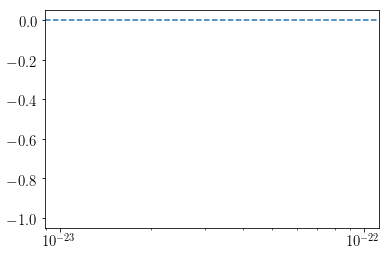

In [123]:
iso_norm = []
dif_norm = []
psc_norm = []
for t in range(trials):
    iso_norm_t = []
    dif_norm_t = []
    psc_norm_t = []
    for best_fit in best_fit_params_arr[len(xsec_inj)*t:len(xsec_inj)*(t+1)]:
        iso_norm_t.append(best_fit[0]['i']/1.06289421 - 1)
        dif_norm_t.append(best_fit[0]['d']/13.9583217 - 1)
        psc_norm_t.append(best_fit[0]['p']/0.90448092 - 1)
    iso_norm.append(iso_norm_t)
    dif_norm.append(dif_norm_t)
    psc_norm.append(psc_norm_t)
plt.plot(xsec_inj, np.percentile(iso_norm, 50, axis=1), label="iso", c="red")
plt.fill_between(xsec_inj, np.percentile(iso_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="iso", facecolor="red", alpha=0.2)
plt.plot(xsec_inj, np.percentile(dif_norm, 50, axis=1), label="dif", c="blue")
plt.fill_between(xsec_inj, np.percentile(dif_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="dif", facecolor="blue", alpha=0.2)
plt.plot(xsec_inj, np.percentile(psc_norm, 50, axis=1), label="psc", c="green")
plt.fill_between(xsec_inj, np.percentile(psc_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="psc", facecolor="green", alpha=0.2)
plt.xscale("log")
plt.axhline(0,ls='--')
#lt.legend()

In [ ]:
ll = []
xsec_arr = np.logspace(-30,-20,101)
for new_n in tqdm_notebook(new_n_arr):
    ll_temp = []
    for xsec in (xsec_arr):
        #ll_temp.append(new_n.ll([13.9583217, 1.06289421,0.90448092, A0/(xsec/xsec0), Fb0]))
        ll_temp.append(new_n.ll([13.9583217, 1.06289421, 0.90448092, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]))
    ll.append(np.array(ll_temp))
ll = np.array(ll)

In [ ]:
for il, ll_arr in enumerate(ll):
    il = il
    p = plt.plot(xsec_arr, 2*(ll_arr-(ll_arr[0])))
    color = (p[0].get_color())
    plt.plot(xsec_inj[il]*np.ones(10), np.linspace(-3e15,3e15,10), c=color, linestyle="--")
plt.plot([1e-50], [1e-50], color="black", label="LL")
plt.plot([1e-50], [1e-50], color="black", linestyle="--", label="$\\langle \\sigma v \\rangle_{inj}$")
plt.axhline(-2.71,ls='--')
plt.xscale("log")
plt.ylim(-5, 3)
plt.xlim(1e-26, 1e-20)
plt.legend(fontsize=12)
plt.ylabel("$LL - LL_{max}$", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle$ [cm$^3$s$^{-1}$]", fontsize=15)
plt.title("Log Likelihood vs. Cross Section", fontsize=15)

In [103]:
trials = 5
xsec_inj_t = []
xsec_rec_t = []
ll_arr = []
xsec_inj = np.logspace(-30, -20, 30)
xsec_test_arr = np.logspace(-40, -23, 101)
xsec_rec_all = []
TS_max_all = []
ll_ary = []
Ab_arr = np.zeros(101)
xsec_max_all = []
for x in xsec_inj:
    xsec_rec_all.append([])
    TS_max_all.append([])
    xsec_max_all.append([])
    ll_ary.append([])

dir_siginj = 'EnergyBins/BlazarsTests/Results/NoBlazNoBkgFloatBlaz/'
for t in tqdm_notebook(range(trials)):
    xsec_inj_temp = []
    xsec_rec_temp = []
    for file in np.sort(os.listdir(dir_siginj)):
        if "True" in file: continue
        if '_'+str(t)+'_siginj_.npz' not in file: continue
        xsec_inj_file = float(re.findall(r'[\d+]?[.]?\d+e-\d+', file)[0])
        xsec_inj_temp.append(float(re.findall(r'[\d+]?[.]?\d+e-\d+', file)[0]))
        arr = np.load(dir_siginj+file)
        ll_ary[np.argmin(np.abs(xsec_inj_file - xsec_inj))].append(arr['arr_1'])
        if np.argmin(np.abs(xsec_inj_file-xsec_inj)) == 18: Ab_arr = (arr['arr_2'])
        if arr['arr_0'][0] > 1e-20: print(xsec_inj_file)
        #xsec_rec_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(arr['arr_0'][0])
        xsec_rec_temp.append(arr['arr_0'])
        TS = 2*(arr['arr_1'] - arr['arr_1'][0])
        TS_max_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(max(TS))
        xsec_max_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(xsec_test_arr[np.argmax(TS)])
        
        #if t == 0: 
        #    p = plt.plot(xsec_test_arr, TS-max(TS), label=str(xsec_inj_file))[0]
        #    plt.axvline(x=xsec_test_arr[np.argmax(2*(arr['arr_1'] - arr['arr_1'][0]))], ls="--", c=p.get_color())
#         for ix in range(len(TS)):

#             if max(TS) - TS[ix] > 2.71 and ix > np.argmax(TS):
#                 xsec_rec_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(xsec_test_arr[ix])
#                 break

        TS_xsec_ary = TS.copy()
        max_loc = np.argmax(TS_xsec_ary)
        max_TS = TS_xsec_ary[max_loc]

        xsec_rec = 1e-50
        for xi in range(max_loc, len(xsec_test_arr)):
            val = TS_xsec_ary[xi] - max_TS
            if val < -2.71:
                scale = (TS_xsec_ary[xi-1]-max_TS+2.71)/(TS_xsec_ary[xi-1]-TS_xsec_ary[xi])
                xsec_rec = xsec_test_arr[xi-1] + scale*(xsec_test_arr[xi] - xsec_test_arr[xi-1])
                xsec_rec_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(xsec_rec)
                break
        print(xsec_inj_file, xsec_rec , arr['arr_0'][0] )
    xsec_inj_t.append(np.array(xsec_inj_temp))
    xsec_rec_t.append(np.array(xsec_rec_temp)[:,0])

1.0826367338740563e-29 8.332374619647003e-27 8.332374619647003e-27
1.1721022975334842e-28 8.332374619647003e-27 8.332374619647003e-27
1.2689610031679287e-27 8.332374619647003e-27 8.332374619647003e-27
1.373823795883261e-26 3.3124997142275252e-31 1.5855876437040788e-29
1.4873521072935117e-25 9.550555917191374e-26 9.550555917191374e-26
1.6102620275609426e-24 1.5868462140068097e-30 1.5868462140068097e-30
1e-30 8.332374619647003e-27 8.332374619647003e-27
2.2122162910704504e-30 8.332374619647003e-27 8.332374619647003e-27
2.3950266199874908e-29 8.332374619647003e-27 8.332374619647003e-27
2.592943797404678e-28 8.332374619647003e-27 8.332374619647003e-27
2.80721620394117e-27 8.332374619647003e-27 8.332374619647003e-27
3.290344562312671e-25 6.604159568351264e-26 6.604159568351264e-26
3.5622478902624516e-24 2.9063421853704715e-28 4.616275066112348e-26
4.893900918477499e-30 8.332374619647003e-27 8.332374619647003e-27
5.298316906283724e-29 8.332374619647003e-27 8.332374619647003e-27
5.736152510448

[1.353132451929483e-06, 1.325226869308148e-06, 1.4459917540588052e-06, 1.345865282236246e-06, 1.3643286858977632e-06, 1.3923624238249099e-06, 1.3583402359990215e-06, 1.37295780615999e-06, 1.372233103087993e-06, 1.4191932967305798e-06, 1.3527182614747713e-06, 1.3268176157671497e-06, 1.343126269459104e-06, 1.3365688176303447e-06, 1.3900985143672317e-06, 1.308443401893965e-06, 1.4476933490087484e-06, 1.3238814885635597e-06, 1.3927110318490242e-06, 1.3531622978141356e-06, 1.4473779631135707e-06, 1.4170158512433294e-06, 1.3474609849323348e-06, 1.3806522877496496e-06, 1.382357055392257e-06, 1.2986757101302137e-06, 1.3840065934739398e-06, 1.3686601062329428e-06, 1.352684366627842e-06, 1.4571000687196955e-06, 1.3322883907229788e-06, 1.3709733468336805e-06, 1.2838881894072885e-06, 1.3692018532624017e-06, 1.4234772298371655e-06, 1.3357337355013421e-06, 1.4167684883842446e-06, 1.4069972412045317e-06, 1.3616139892336331e-06, 1.357279935269583e-06, 1.3309653374449326e-06, 1.369304007424198e-06, 1.3

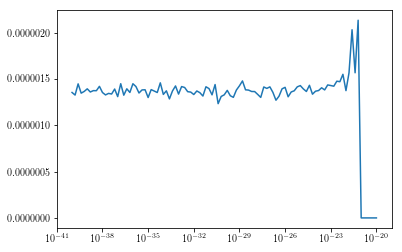

In [96]:
Ab_arr2 = []
for iA, A in enumerate(Ab_arr):
    Ab_arr2.append(A[0][0])
plt.plot(xsec_test_arr, Ab_arr2)
plt.xscale("log")
print(Ab_arr2)

In [107]:
xsec_rec_ave = []
xsec_rec_1stdd = []
xsec_rec_1stdu = []
for i in range(len(xsec_rec_all)):
    if len(xsec_rec_all[i]) == 0: 
        xsec_rec_ave.append(0)
        xsec_rec_1stdd.append(0)
        xsec_rec_1stdu.append(0)
        continue
    xsec_rec_all[i] = np.array(xsec_rec_all[i])
    xsec_rec_ave.append(np.percentile(xsec_rec_all[i], 50))
    xsec_rec_1stdd.append(np.percentile(xsec_rec_all[i], 16))
    xsec_rec_1stdu.append(np.percentile(xsec_rec_all[i], 84))
    
xsec_max_ave = []
xsec_max_1stdd = []
xsec_max_1stdu = []
for i in range(len(xsec_max_all)):
    if len(xsec_max_all[i]) == 0: 
        xsec_max_ave.append(0)
        xsec_max_1stdd.append(0)
        xsec_max_1stdu.append(0)
        continue

    xsec_max_all[i] = np.array(xsec_max_all[i])
    xsec_max_ave.append(np.percentile(xsec_max_all[i], 50))
    xsec_max_1stdd.append(np.percentile(xsec_max_all[i], 16))
    xsec_max_1stdu.append(np.percentile(xsec_max_all[i], 84))

TS_max_ave = []
TS_max_1stdd = []
TS_max_1stdu = []
for i in range(len(TS_max_all)):
    if len(TS_max_all[i]) == 0: 
        TS_max_ave.append(0)
        TS_max_1stdd.append(0)
        TS_max_1stdu.append(0)
        continue
    TS_max_all[i] = np.array(TS_max_all[i])
    TS_max_ave.append(np.percentile(TS_max_all[i], 50))
    TS_max_1stdd.append(np.percentile(TS_max_all[i], 16))
    TS_max_1stdu.append(np.percentile(TS_max_all[i], 84))

[array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 8.33237462e-27, 8.33237462e-27,
       8.33237462e-27]), array([8.33237462e-27, 8.33237462e-27, 

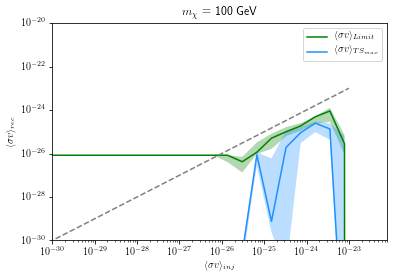

In [108]:
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.57, 0.34, 0.3, 0.3]
#ax2 = fig.add_axes([left, bottom, width, height])
print(xsec_rec_all)
for t in range(trials):
    xsec_rec_arr = xsec_rec_t[t][xsec_inj_t[t].argsort()]
    #plt.plot(np.sort(xsec_inj_t[t]), xsec_rec_arr)
ax1.set_title("$m_{\chi}$ = 100 GeV")
print(xsec_rec_ave[18])
print(xsec_inj[18])
ax1.plot(xsec_inj, xsec_rec_ave, c="green", label="$\langle\sigma v \\rangle_{Limit}$")
ax1.fill_between(xsec_inj, xsec_rec_1stdd, xsec_rec_1stdu, facecolor="green", alpha=0.3)
ax1.plot(xsec_inj, xsec_max_ave, c="dodgerblue", label="$\langle\sigma v \\rangle_{TS_{max}}$")
ax1.fill_between(xsec_inj, xsec_max_1stdd, xsec_max_1stdu, facecolor="dodgerblue", alpha=0.3)
ax1.plot((xsec_test_arr), np.sort(xsec_test_arr), linestyle="--", c="grey")
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlim(1e-30,8e-23)
ax1.set_ylim(1e-30,1e-20)
ax1.set_xlabel("$\langle\sigma v \\rangle_{inj}$")
ax1.set_ylabel("$\langle\sigma v \\rangle_{rec}$")

#ax2.plot(xsec_inj, TS_max_ave, c="red")
#ax2.fill_between(xsec_inj, TS_max_1stdd, TS_max_1stdu, facecolor="red", alpha=0.3)
#ax2.set_yscale("log")
#x2.set_xscale("log")
#ax2.set_xlim(1e-30,1e-22)
#ax2.set_ylim(1e-3, 1e3)
#ax2.set_ylabel("$TS_{max}$")
ax1.legend()

ValueError: x and y can be no greater than 2-D, but have shapes (101,) and (101, 1, 6)

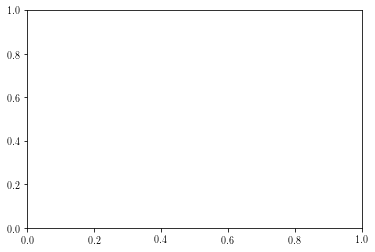

In [86]:
plt.plot(xsec_test_arr, Ab_arr)
plt.xscale("log")
plt.ylim(1e-30, 1e-4)
plt.yscale("log")

[   1.            1.            1.            1.            1.
    1.            1.            1.            1.            1.
    1.            1.            1.            1.            1.28259242
    3.02736846    6.88719043   15.91247528   36.41346877   77.31143871
  153.89421293  284.29578734  499.00749716  780.23464    1000.
 1000.         1000.         1000.         1000.         1000.        ]


NameError: name 'cut' is not defined

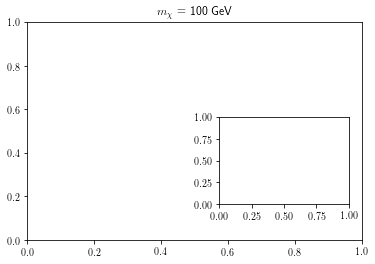

In [19]:
from scipy import interp
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.57, 0.25, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

for t in range(trials):
    xsec_rec_arr = xsec_rec_t[t][xsec_inj_t[t].argsort()]
    #plt.plot(np.sort(xsec_inj_t[t]), xsec_rec_arr)

subs2xsec = np.load("subhalos2xsec.npy")
n_subs = subs2xsec[0]
xsec_nsubs = subs2xsec[1]
subs_inj= interp(xsec_inj, xsec_nsubs, n_subs)
print(subs_inj)
subs_rec_ave = interp(xsec_rec_ave, xsec_nsubs, n_subs)
subs_rec_1stdd = interp(xsec_rec_1stdd, xsec_nsubs, n_subs)
subs_rec_1stdu = np.interp(xsec_rec_1stdu, xsec_nsubs, n_subs)
subs_max_ave = np.interp(xsec_max_ave, xsec_nsubs, n_subs)
subs_max_1stdd = np.interp(xsec_max_1stdd, xsec_nsubs, n_subs)
subs_max_1stdu = np.interp(xsec_max_1stdu, xsec_nsubs, n_subs)
subs_test_arr = np.interp(xsec_test_arr, xsec_nsubs, n_subs)
    
ax1.set_title("$m_{\chi}$ = 100 GeV")
ax1.plot(subs_inj[:cut], subs_rec_ave, c="green", label="$N_{subs, Limit}$")
ax1.fill_between(subs_inj[:cut], subs_rec_1stdd, subs_rec_1stdu, facecolor="green", alpha=0.3)
ax1.plot(subs_inj[:cut], subs_max_ave, c="dodgerblue", label="$N_{subs, TS_{max}}$")
ax1.fill_between(subs_inj[:cut], subs_max_1stdd, subs_max_1stdu, facecolor="dodgerblue", alpha=0.3)
ax1.plot((subs_test_arr), np.sort(subs_test_arr), linestyle="--", c="grey")
#ax1.set_yscale("log")
#ax1.set_xscale("log")
ax1.set_xlim(1,1000)
ax1.set_ylim(1,1000)
ax1.set_xlabel("$N_{subs, inj}$")
ax1.set_ylabel("$N_{subs, rec}$")
ax2.plot(subs_inj[:cut], TS_max_ave, c="red")
ax2.fill_between(subs_inj[:cut], TS_max_1stdd, TS_max_1stdu, facecolor="red", alpha=0.3)
ax2.set_yscale("log")
#ax2.set_xscale("log")
ax2.set_xlim(1,100)
ax2.set_ylim(1e-3, 1e3)
ax2.set_ylabel("$TS_{max}$")
ax1.legend()

Text(0,0.5,'$TS_{max}$')

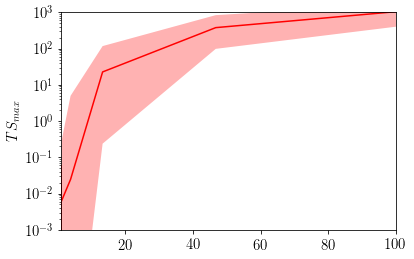

In [107]:
plt.plot(subs_inj[:cut], TS_max_ave, c="red")
plt.fill_between(subs_inj[:cut], TS_max_1stdd, TS_max_1stdu, facecolor="red", alpha=0.3)
plt.yscale("log")
#ax2.set_xscale("log")
plt.xlim(1,100)
plt.ylim(1e-3, 1e3)
plt.ylabel("$TS_{max}$")

In [25]:
mass_arr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])
# mass_arr2 = []
# for im in range(len(mass_arr)):
#     if im%3==0: mass_arr2.append(mass_arr[im])
# mass_arr = np.array(mass_arr2)
# print(mass_arr)
#mass_arr = np.array([4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])
ll_ary = []
xsec_rec = []
xsec_rec_dir = 'EnergyBins/lim/101520Lim/'
for i in mass_arr:
    xsec_rec.append([])
for file in os.listdir(xsec_rec_dir):
    if ".npz" not in file: continue
    mass = float(re.findall(r'lim_5_[\d+]?[.]?\d+.\d+', file)[0][6:])
    if mass == 100: ll_ary.append(np.load(xsec_rec_dir+file)['arr_1'])
    if mass in mass_arr: xsec_rec[ np.argmax(mass_arr == mass) ].append(np.load(xsec_rec_dir+file)['arr_0'][0])
xsec_rec_ave = []
xsec_rec_1stdu = []
xsec_rec_1stdd = []
xsec_rec_2stdu = []
xsec_rec_2stdd = []
for i in range(len(xsec_rec)):
    xsec_rec[i] = np.array(xsec_rec[i])
    if len(xsec_rec[i])==0: 
        xsec_rec_ave.append(0)
        xsec_rec_1stdu.append(0)
        xsec_rec_1stdd.append(0)
        xsec_rec_2stdu.append(0)
        xsec_rec_2stdd.append(0)
        continue
    xsec_rec_ave.append(np.percentile(xsec_rec[i], 50))
    xsec_rec_1stdu.append(np.percentile(xsec_rec[i], 84))
    xsec_rec_1stdd.append(np.percentile(xsec_rec[i], 16))
    xsec_rec_2stdu.append(np.percentile(xsec_rec[i], 97.5))
    xsec_rec_2stdd.append(np.percentile(xsec_rec[i], 2.5))

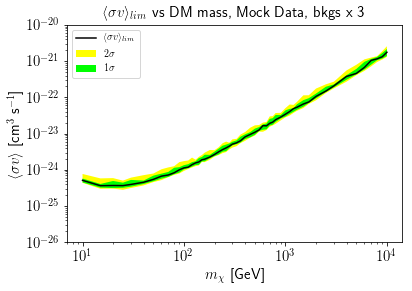

In [26]:
from matplotlib import rc
rc('text', usetex=True)
fig, ax = plt.subplots()
plt.plot((mass_arr), (xsec_rec_ave), label="$\\langle \\sigma v \\rangle_{lim}$", c="black")
plt.fill_between((mass_arr), (xsec_rec_2stdd), (xsec_rec_2stdu), label="$2 \\sigma$", facecolor="yellow")
plt.fill_between((mass_arr), (xsec_rec_1stdd), (xsec_rec_1stdu), label="$1 \\sigma$", facecolor="lime")
#plt.axhline(2.310129700083158e-24,ls='--')
plt.ylim(1e-26, 1e-20)
#plt.xlim(200,300)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=10, loc=2)
plt.xlabel("$m_{\chi}$ [GeV]", fontsize=15)
plt.ylabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.title("$\\langle \\sigma v \\rangle_{lim}$ vs DM mass, Mock Data, bkgs x 3", fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);

In [104]:
xsec_test_arr = np.logspace(-40, -23, 101)
ll_ave = []
ll_1stdu = []
ll_1stdd = []
ll_2stdu = []
ll_2stdd = []
for il in range(len(ll_ary[:1])):
    il = 0
    print(xsec_inj[il])
    ll_ary2 = (ll_ary[il])
    #plt.plot(xsec_test_arr, ll_ary2[il])
    if ll_ary2 == []:
        ll_ave.append(np.zeros(101))
        ll_1stdu.append(np.zeros(101))
        ll_1stdd.append(np.zeros(101))
        ll_2stdu.append(np.zeros(101))
        ll_2stdd.append(np.zeros(101))
        continue
    ll_ave.append(np.percentile(ll_ary2, 50, axis=0))
    ll_1stdu.append(np.percentile(ll_ary2, 84, axis=0))
    ll_1stdd.append(np.percentile(ll_ary2, 16, axis=0))
    ll_2stdu.append(np.percentile(ll_ary2, 97.5, axis=0))
    ll_2stdd.append(np.percentile(ll_ary2, 2.5, axis=0))

1e-30


(-12, 3)

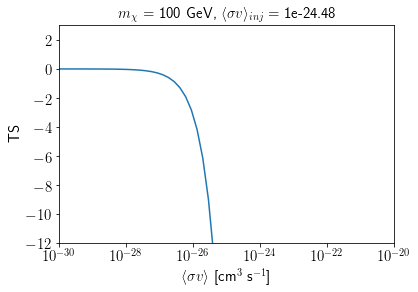

In [105]:
fig, ax = plt.subplots()
for il in range(len(ll_ave)):
    ll_ave[il] = np.array(ll_ave[il])
    plt.plot(xsec_test_arr, 2*(ll_ave[il]-(ll_ave[il][0])), label="Mean TS")
    #plt.fill_between(xsec_test_arr, 2*(ll_2stdd[il]-ll_2stdd[il][0]), 2*(ll_2stdu[il]-ll_2stdu[il][0]), facecolor="yellow", label="$2 \\sigma$")
    #plt.fill_between(xsec_test_arr, 2*(ll_1stdd[il]-ll_1stdd[il][0]), 2*(ll_1stdu[il]-ll_1stdu[il][0]), facecolor="limegreen", label="$1 \\sigma$")
#plt.yscale("log")
plt.xscale("log")
#plt.ylim(3e13,6e13)
plt.xlim(1e-30, 1e-20)
plt.title("$m_{\chi}$ = 100 GeV, $\\langle \\sigma v \\rangle_{inj} = $ 1e"+str(round(np.log10(xsec_inj[16]), 2)), fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.ylabel("TS", fontsize = 15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);
#plt.legend(fontsize=15)
#plt.ylim(-423500, -421500)
plt.ylim(-12, 3)

ValueError: x and y must have same first dimension, but have shapes (51,) and (101,)

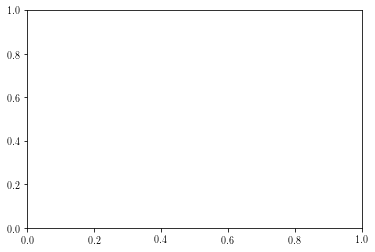

In [24]:
d_arr = []
i_arr = []
p_arr = []
limdir = "EnergyBins/lim/101520idp/"
xsec_rec = 0
n=0
for ib in [0, 1]:
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "0.0" in file:
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
    # d = 0.9095
    # i = 0.0862
    # p = 0.03719

    if ib == 0:
        d_n =  0.8999
        i_n =  0.1433
        p_n =  0.03794
    if ib == 1:
        d_n =   0.9784
        i_n =  0.02912
        p_n =  0.02612   

    #d = 13.9583217
    #i = 1.06289421
    #p = 0.90448092
    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
    plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
    plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
    plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-.3, .2)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{0.0}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

    d_arr = []
    i_arr = []
    p_arr = []
    xsec_rec = 0
    n=0
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "1e-23" in file: 
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
            xsec_rec += np.load(limdir+file)['arr_0'][0]

    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
    plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
    plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
    plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-.3, .2)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{1e-23}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

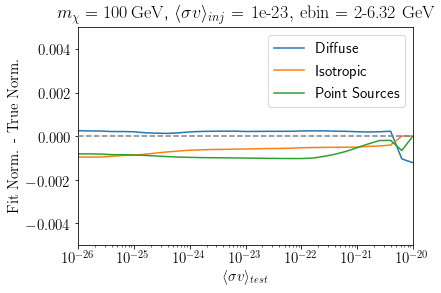

In [122]:
d_arr = []
i_arr = []
p_arr = []
limdir = "EnergyBins/lim/101520idp/"
xsec_rec = 0
n=0
for ib in [0]:
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "0.0" in file:
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
    # d = 0.9095
    # i = 0.0862
    # p = 0.03719

    if ib == 0:
        d_n =  0.8999
        i_n =  0.1433
        p_n =  0.03794
    if ib == 1:
        d_n =   0.9784
        i_n =  0.02912
        p_n =  0.02612   

    #d = 13.9583217
    #i = 1.06289421
    #p = 0.90448092
#     plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
#     plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
#     plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
#     plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
#     plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
#     plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
#     plt.xscale("log")
#     plt.xlim(1e-26, 1e-20)
#     plt.axhline(0,ls='--', zorder=10, c="grey")
#     plt.ylim(-.3, .2)
#     plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
#     plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
#     plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{0.0}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
#     plt.legend()

    d_arr2 = []
    i_arr2 = []
    p_arr2 = []
    xsec_rec = 0
    n=0
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "1e-23" in file: 
            d_arr2.append([])
            i_arr2.append([])
            p_arr2.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr2[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr2[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr2[-1].append(np.load(limdir+file)['arr_4'][i][0])
            xsec_rec += np.load(limdir+file)['arr_0'][0]

    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)- np.percentile(d_arr2, 50, axis=0), label="Diffuse")
    #plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)- np.percentile(d_arr, 50, axis=0), np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)- np.percentile(i_arr2, 50, axis=0), label="Isotropic")
    #plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)- np.percentile(p_arr2, 50, axis=0), label="Point Sources")
    #plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-5e-3, 5e-3)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{1e-23}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

(1e-26, 1e-22)

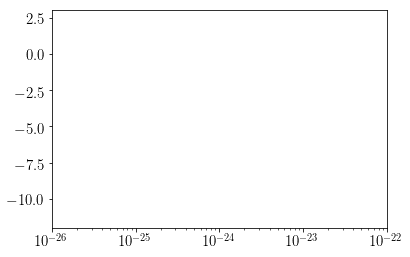

In [62]:
file= np.load("EnergyBins/lim/init220/lim_fixed_4.6415888336127916e-24_False_1_siginj_subs23.333333333333332_2_220test_init_.npz")['arr_1']
plt.plot(xsec_test_arr, 2*(file-file[0]))
plt.xscale("log")
plt.ylim(-12, 3)
plt.xlim(1e-26, 1e-22)